https://github.com/jacobgil/keras-cam/blob/master/cam.py

In [1]:
import tensorflow as tf
from vis.utils import utils
from tensorflow.python.keras import activations
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras import backend as K
import numpy as np
from PIL import Image

Using TensorFlow backend.


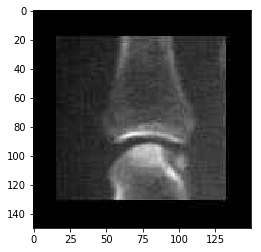

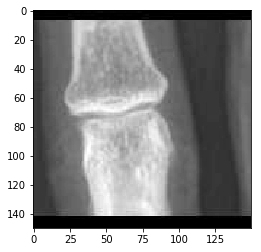

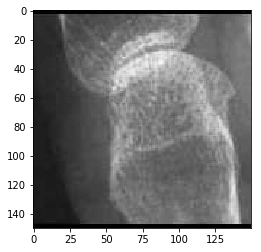

In [2]:
import h5py
from matplotlib import pyplot as plt
# load test images
with h5py.File('/data/joint_scoring/img_test.h5', 'r') as hf:
    img_test = hf['img_test'][:]

plt.close()
for i in range(3):    
    plt.imshow(img_test[i].squeeze(), cmap='gray')
    plt.show()  

In [17]:
with h5py.File('/data/joint_scoring/labels_test.h5', 'r') as hf:
    labels_test = hf['labels_test'][:]
    
print(labels_test[:3])

[ 0.  0.  2.]


In [18]:
# load classification model
loaded_model = load_model("/data/joint_scoring/models/20171108_195245.h5")

loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 150, 150, 32)      0         
__________

In [19]:
loaded_model.layers[22]

In [20]:
from tensorflow.python.keras.models import Sequential

config = loaded_model.get_config()
config = config[0:23]
model = Sequential.from_config(config)
weights = loaded_model.get_weights()
model.set_weights(weights)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 150, 150, 32)      0         
__________

In [95]:
def attention_map(img):
    width, height, _ = img.shape
    img = img.reshape(1, 150, 150, 1)
    embeddings = model.predict(img)
    conv_outputs = embeddings[0, :, :, :]
    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
    class_weights = loaded_model.layers[23].get_weights()[0]
    for i, w in enumerate(class_weights):
        cam += w * conv_outputs[:, :, i]
    cam /= np.max(cam)
    cam /= np.max(cam)
    heatmap = Image.fromarray(np.uint8(plt.cm.viridis(cam)*255))
    heatmap = heatmap.resize((width, height))
    heatmap.putalpha(64)
    img_org = Image.fromarray(np.uint8(img.squeeze()))
    img_org = img_org.convert('RGBA')
    img_new = Image.alpha_composite(im1=img_org, im2=heatmap)
    plt.close()
    plt.imshow(img_new)
    plt.show()

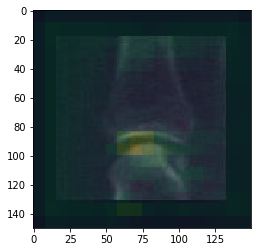

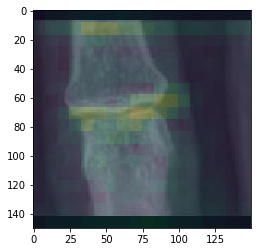

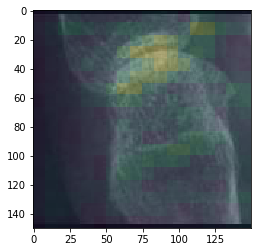

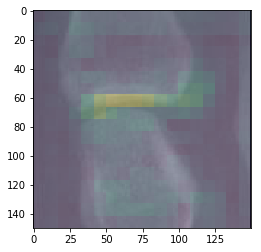

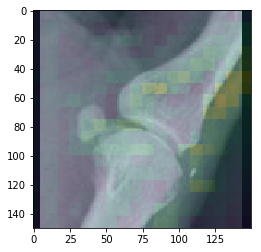

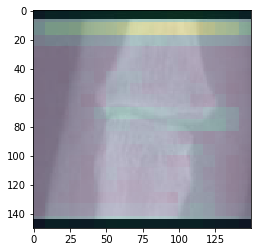

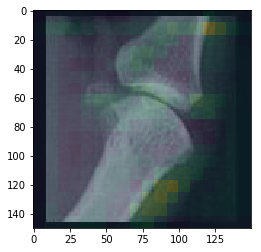

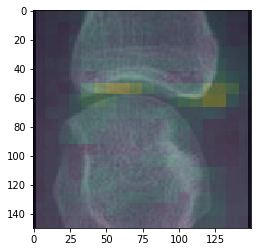

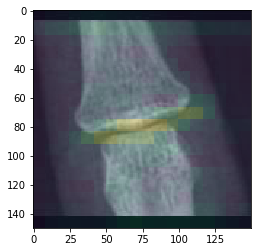

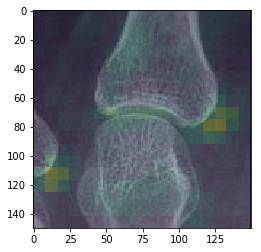

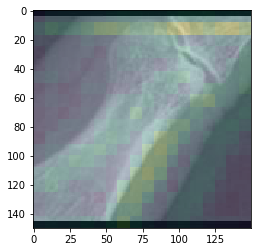

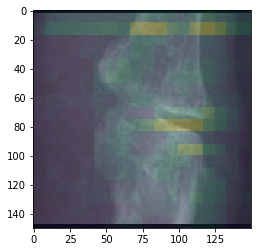

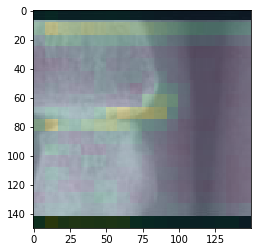

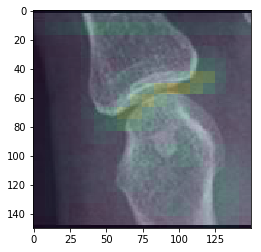

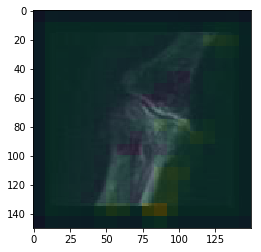

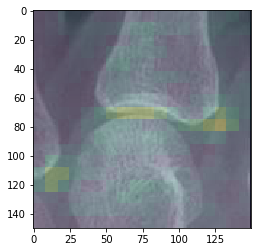

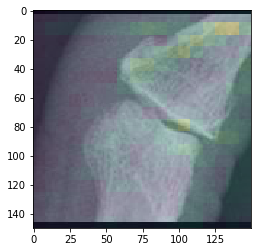

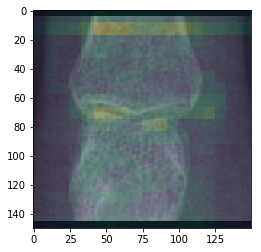

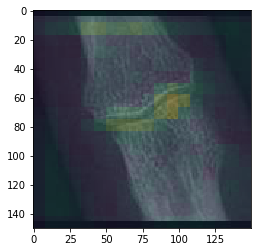

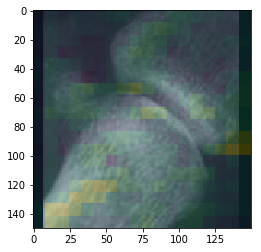

In [96]:
for i in range(20):
    attention_map(img_test[i])